In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(1_000_000_000_000) ## 1TB?

from calitp.tables import tbl
from calitp import query_sql

import pandas as pd
import geopandas as gpd
from siuba import *

import shared_utils

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Read In / Transform SB MTD Ridership Data

In [2]:
GCS_FILE_PATH = 'gs://calitp-analytics-data/data-analyses/ahsc_grant/'

In [3]:
# reads in multiple sheets as a dictionary
yr_sbmtd_raw = pd.read_excel(f'{GCS_FILE_PATH}SYSTEM WIDE STOP USAGE FY21-22.xlsx', sheet_name=None)

In [4]:
# add sheet names (keys) as column names, then concatenate
for key, value in yr_sbmtd_raw.items():
    value['daytype'] = f'{key}'

list(yr_sbmtd_raw.values()) [0]['daytype']

0       WKDY
1       WKDY
2       WKDY
3       WKDY
4       WKDY
        ... 
2210    WKDY
2211    WKDY
2212    WKDY
2213    WKDY
2214    WKDY
Name: daytype, Length: 2215, dtype: object

In [5]:
yr_sbmtd_all = pd.concat(yr_sbmtd_raw, ignore_index=True)

yr_sbmtd_all

,ROUTE_NUMBER,ROUTE_NAME,DIRECTION_NAME,ROUTE_DIRECTION,STOP_NAME,STOP_ID,STOP_ID_NEAR,XBOARDINGS,XALIGHTINGS,XWHEELCHAIRS,XBICYCLES,XTRIPS,daytype
0,2,2: Eastside,EAST SB,2E,NaN,99999,4,41,1,-5,0,18,WKDY
1,2,2: Eastside,EAST SB,2E,NaN,99999,7,94,15,-43,0,86,WKDY
2,3,3: Oak Park,DOWNTOWN SB,3D,Treasure/Calle Real,406,406,445,434,-1,0,4349,WKDY
3,5,5: Mesa/La Cumbre,DOWNTOWN SB,5D,Transit Center,4,4,9,8833,-1412,0,2956,WKDY
4,5,5: Mesa/La Cumbre,DOWNTOWN SB,5D,La Cumbre Plaza/Plaza Ave,364,364,1453,64,-14,0,1999,WKDY
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4420,24,24X: UCSB Express,CAMINO REAL MKT,24C,TC,100222,100222,0,0,0,0,900,SUN
4421,25,25: Ellwood,CAMINO REAL MKT,25C,Hollister/Storke,-15,-15,0,497,-13,0,409,SUN
4422,25,25: Ellwood,WINCHESTER CYN,25W,NaN,99999,143,17,19,-3,0,19,SUN
4423,28,28: UCSB Shuttle,UCSB,28U,UCSB North Hall Outbound,42,42,4,2646,-61,0,569,SUN


In [6]:
# standardize stop ids
day_cols = {'WKDY': 'weekday_ons', 'SAT': 'sat_ons', 'SUN': 'sun_ons'}

yr_sbmtd_all = (yr_sbmtd_all
                 >> mutate(STOP_ID_clean = if_else(_.STOP_ID!=99999,_.STOP_ID,_.STOP_ID_NEAR),
                           DAY_TYPE = _.daytype.apply(lambda x: day_cols[x]))
               )


In [7]:
# want to keep stop name as recommended by sbmtd staff
name_id_dict = (yr_sbmtd_all 
                >> distinct(_.STOP_ID_clean,_.STOP_NAME)
                >> arrange(_.STOP_ID_clean,_.STOP_NAME)
                >> filter(_.STOP_NAME.notna()) #this expression drops NAs
                >> rename(STOP_NAME_clean = "STOP_NAME")
               )

name_id_dict.STOP_ID_clean.value_counts()

-51        1
 840       1
 816       1
 819       1
 823       1
          ..
 351       1
 353       1
 354       1
 355       1
 100314    1
Name: STOP_ID_clean, Length: 755, dtype: int64

In [8]:
yr_sbmtd_grouped = (yr_sbmtd_all    
                >> left_join(_,name_id_dict)    
                >> group_by(_.STOP_ID_clean,_.STOP_NAME_clean, _.DAY_TYPE)
                >> summarize(stop_total_ons = _.XBOARDINGS.sum())
                )

yr_sbmtd_grouped >> head(5)

,STOP_ID_clean,STOP_NAME_clean,DAY_TYPE,stop_total_ons
0,-51,Pacific Oaks/Phelps,sat_ons,0
1,-51,Pacific Oaks/Phelps,sun_ons,0
2,-51,Pacific Oaks/Phelps,weekday_ons,2
3,-49,Pueblo/Castillo Out,sat_ons,116
4,-49,Pueblo/Castillo Out,sun_ons,109


In [9]:
yr_sbmtd_grouped = (yr_sbmtd_grouped
                     >> spread("DAY_TYPE", "stop_total_ons")
                     #>> rename(stop_id = _.STOP_ID)
                     >> mutate(calitp_itp_id = 293,
                              stop_code=_.STOP_ID_clean.apply(str))
                    )

yr_sbmtd_grouped >> head (5)

,STOP_ID_clean,STOP_NAME_clean,sat_ons,sun_ons,weekday_ons,calitp_itp_id,stop_code
0,-51,Pacific Oaks/Phelps,0.0,0.0,2.0,293,-51
1,-49,Pueblo/Castillo Out,116.0,109.0,2734.0,293,-49
2,-45,Cathedral Oaks and Brandon,61.0,42.0,411.0,293,-45
3,-39,Hollister/Los Carneros Road,95.0,64.0,879.0,293,-39
4,-38,Hollister/Los Carneros Way,77.0,96.0,680.0,293,-38


In [10]:
len(yr_sbmtd_grouped)

755

In [11]:
# use same date as LA Metro for now
sbmtd_stops = shared_utils.gtfs_utils.get_stops('2022-03-15', [293])
len(sbmtd_stops)

607

In [12]:
stops_to_join = (sbmtd_stops 
                 >> select(_.calitp_itp_id, _.stop_id, _.stop_code,_.stop_name, _.geometry)
                )

In [13]:
yr_sbmtd_geo_code = stops_to_join >> inner_join(_, yr_sbmtd_grouped, on = ['calitp_itp_id', 'stop_code'])

In [14]:
yr_sbmtd_geo_code.info() 

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 571 entries, 0 to 570
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   calitp_itp_id    571 non-null    int64   
 1   stop_id          571 non-null    object  
 2   stop_code        571 non-null    object  
 3   stop_name        571 non-null    object  
 4   geometry         571 non-null    geometry
 5   STOP_ID_clean    571 non-null    int64   
 6   STOP_NAME_clean  571 non-null    object  
 7   sat_ons          470 non-null    float64 
 8   sun_ons          436 non-null    float64 
 9   weekday_ons      571 non-null    float64 
dtypes: float64(3), geometry(1), int64(2), object(4)
memory usage: 49.1+ KB


Issue: negative stop ids are not matching stop codes in warehouse data

Approach:
- inner join on stop code
- anti-join both datasets to get remainders
- join remainders on name (levenshtein edit distance or just change "/" to " & ")
- concatenate

In [17]:
stops_remainder = (stops_to_join 
    >> anti_join(_, yr_sbmtd_grouped, on = ['calitp_itp_id', 'stop_code'])
                    )

len(stops_remainder)

36

In [31]:
stops_remainder

,calitp_itp_id,stop_id,stop_code,stop_name,geometry
4,293,809,755,Hollister & La Patera,POINT (-119.84150 34.43264)
25,293,799,289,Hollister & Pine,POINT (-119.82623 34.43571)
36,293,792,279,Hollister & Los Carneros Road,POINT (-119.85909 34.43033)
65,293,802,294,Hollister & El Mercado,POINT (-119.76226 34.44044)
82,293,815,930,Hollister & Ward,POINT (-119.81637 34.43514)
85,293,811,824,State & Highway 154,POINT (-119.75885 34.44032)
96,293,780,126,Anacapa & Anapamu,POINT (-119.70295 34.42408)
132,293,805,372,Storke & Whittier,POINT (-119.86962 34.42211)
135,293,813,87,Hollister & Arboleda,POINT (-119.77195 34.43970)
137,293,795,285,Hollister & Adams,POINT (-119.84794 34.43127)


In [18]:
yr_sbmtd_remainder = (yr_sbmtd_grouped 
    >> anti_join(_, stops_to_join, on = ['calitp_itp_id', 'stop_code'])
                    )

len(yr_sbmtd_remainder)

184

Many more stops with ridership than stops in data:
- Many have unuseable names and no ridership
- filter to stops with any ridership

In [20]:
shared_utils.rt_utils.show_full_df(yr_sbmtd_remainder >> count(_.STOP_NAME_clean,_.weekday_ons))

,STOP_NAME_clean,weekday_ons,n
0,AbreCDSO,0.0,1
1,AlamBasO,0.0,1
2,AlamPadN,0.0,1
3,AlamPadO,0.0,1
4,Alameda/Bassano,0.0,1
5,Anacapa/Anapamu,5576.0,1
6,ArBuBePa,0.0,1
7,BranEveO,0.0,1
8,BranEver,0.0,1
9,CVRHoSp,0.0,1


In [21]:
yr_sbmtd_remainder = (yr_sbmtd_remainder
                      >> filter ((_.weekday_ons+_.sat_ons+_.sun_ons)>=1)
                      >> select(-_.stop_code)
                     )
len(yr_sbmtd_remainder)

42

In [22]:
yr_sbmtd_remainder

,STOP_ID_clean,STOP_NAME_clean,sat_ons,sun_ons,weekday_ons,calitp_itp_id,stop_code
0,-51,Pacific Oaks/Phelps,0.0,0.0,2.0,293,-51
1,-49,Pueblo/Castillo Out,116.0,109.0,2734.0,293,-49
2,-45,Cathedral Oaks and Brandon,61.0,42.0,411.0,293,-45
3,-39,Hollister/Los Carneros Road,95.0,64.0,879.0,293,-39
4,-38,Hollister/Los Carneros Way,77.0,96.0,680.0,293,-38
5,-37,Hollister/Ward,288.0,169.0,2699.0,293,-37
6,-36,State/Valerio,323.0,252.0,1798.0,293,-36
7,-35,Hollister/Arboleda,645.0,551.0,7015.0,293,-35
8,-34,State/Pueblo,295.0,187.0,2139.0,293,-34
9,-33,State/Highway 154,795.0,649.0,6398.0,293,-33


In [28]:
from nltk import distance

In [70]:
yr_sbmtd_geo_name = pd.merge(stops_remainder,yr_sbmtd_remainder,how="cross")

yr_sbmtd_geo_name.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1512 entries, 0 to 1511
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   calitp_itp_id_x  1512 non-null   int64   
 1   stop_id          1512 non-null   object  
 2   stop_code_x      1512 non-null   object  
 3   stop_name        1512 non-null   object  
 4   geometry         1512 non-null   geometry
 5   STOP_ID_clean    1512 non-null   int64   
 6   STOP_NAME_clean  1512 non-null   object  
 7   sat_ons          1512 non-null   float64 
 8   sun_ons          1512 non-null   float64 
 9   weekday_ons      1512 non-null   float64 
 10  calitp_itp_id_y  1512 non-null   int64   
 11  stop_code_y      1512 non-null   object  
dtypes: float64(3), geometry(1), int64(3), object(5)
memory usage: 153.6+ KB


In [71]:
# source: https://stackoverflow.com/questions/42892617/edit-distance-between-two-pandas-columns 
yr_sbmtd_geo_name["edit_dist"] = yr_sbmtd_geo_name.loc[:, ["STOP_NAME_clean","stop_name"]].apply(lambda x: distance.edit_distance(*x), axis=1)

In [69]:
yr_sbmtd_geo_name2 = (yr_sbmtd_geo_name
                     >> group_by(_.stop_name,_.stop_id,)
                     >> filter(_.edit_dist==_.edit_dist.min())
                     >> ungroup()
                     >> arrange(_.stop_name)
                    )

yr_sbmtd_geo_name2

,calitp_itp_id_x,stop_id,stop_code_x,stop_name,geometry,STOP_ID_clean,STOP_NAME_clean,sat_ons,sun_ons,weekday_ons,calitp_itp_id_y,stop_code_y,edit_dist
8,293,780,126,Anacapa & Anapamu,POINT (-119.70295 34.42408),-2,Anacapa/Anapamu,788.0,503.0,5576.0,293,-2,3
22,293,1164,1100,Cathedral Oaks and Brandon,POINT (-119.89196 34.44141),-45,Cathedral Oaks and Brandon,61.0,42.0,411.0,293,-45,0
41,293,806,520,Fairview & Carson,POINT (-119.83070 34.43280),-28,Fairview/Carson,513.0,325.0,2587.0,293,-28,3
11,293,795,285,Hollister & Adams,POINT (-119.84794 34.43127),-17,Hollister/Adams,370.0,276.0,3955.0,293,-17,3
26,293,781,180,Hollister & Aero Camino,POINT (-119.84800 34.43149),-3,Hollister/Aero Camino,163.0,211.0,1735.0,293,-3,3
10,293,813,87,Hollister & Arboleda,POINT (-119.77195 34.43970),-35,Hollister/Arboleda,645.0,551.0,7015.0,293,-35,3
39,293,807,752,Hollister & Auhay East,POINT (-119.77419 34.43930),-29,Hollister/Auhay East,185.0,125.0,1602.0,293,-29,3
21,293,801,293,Hollister & Auhay West,POINT (-119.78139 34.43795),-23,Hollister/Auhay West,254.0,174.0,1814.0,293,-23,3
33,293,800,290,Hollister & Community Center,POINT (-119.82350 34.43556),-22,Hollister/Community Center,1852.0,1427.0,12347.0,293,-22,3
23,293,794,280,Hollister & Coromar,POINT (-119.86311 34.43037),-30,Hollister/Coromar,440.0,287.0,3187.0,293,-30,3


Remaining issue:
several stop names have 2 associated invalid codes. 
- Hollister/Walnut and Hollister/La Patera need to be assigned
- Hollister/Los Carneros and Hollister/Coromar need to be aggregated. These boardings may go to the other side of the street

In [85]:
# throw out 4 stops with unclear data for now
yr_sbmtd_geo_name3 = (yr_sbmtd_geo_name2
                      >> group_by(_.stop_id)
                      >> filter(lambda x: len(x) < 2) #keep if only member of group
                      >> ungroup()
                      >> select(-_.calitp_itp_id_y,-_.stop_code_y,-_.edit_dist)
                      >> rename(calitp_itp_id="calitp_itp_id_x", stop_code="stop_code_x")
                     )                    

yr_sbmtd_geo_name3

,calitp_itp_id,stop_id,stop_code,stop_name,geometry,STOP_ID_clean,STOP_NAME_clean,sat_ons,sun_ons,weekday_ons
0,293,799,289,Hollister & Pine,POINT (-119.82623 34.43571),-21,Hollister/Pine,4187.0,3546.0,30178.0
1,293,802,294,Hollister & El Mercado,POINT (-119.76226 34.44044),-24,Hollister/El Mercado,354.0,240.0,3689.0
2,293,815,930,Hollister & Ward,POINT (-119.81637 34.43514),-37,Hollister/Ward,288.0,169.0,2699.0
3,293,811,824,State & Highway 154,POINT (-119.75885 34.44032),-33,State/Highway 154,795.0,649.0,6398.0
4,293,780,126,Anacapa & Anapamu,POINT (-119.70295 34.42408),-2,Anacapa/Anapamu,788.0,503.0,5576.0
5,293,805,372,Storke & Whittier,POINT (-119.86962 34.42211),-27,Storke/Whittier,74.0,90.0,3431.0
6,293,813,87,Hollister & Arboleda,POINT (-119.77195 34.43970),-35,Hollister/Arboleda,645.0,551.0,7015.0
7,293,795,285,Hollister & Adams,POINT (-119.84794 34.43127),-17,Hollister/Adams,370.0,276.0,3955.0
8,293,786,271,Hollister & Lopez,POINT (-119.83580 34.43435),-8,Hollister/Lopez,70.0,90.0,413.0
9,293,782,251,State & Alamar,POINT (-119.72450 34.43814),-4,State/Alamar,1174.0,995.0,7328.0


In [86]:
# set tables together
gdfs = [yr_sbmtd_geo_name3,yr_sbmtd_geo_code]

yr_sbmtd_geo_all = pd.concat(gdfs, ignore_index=True)

yr_sbmtd_geo_all

,calitp_itp_id,stop_id,stop_code,stop_name,geometry,STOP_ID_clean,STOP_NAME_clean,sat_ons,sun_ons,weekday_ons
0,293,799,289,Hollister & Pine,POINT (-119.82623 34.43571),-21,Hollister/Pine,4187.0,3546.0,30178.0
1,293,802,294,Hollister & El Mercado,POINT (-119.76226 34.44044),-24,Hollister/El Mercado,354.0,240.0,3689.0
2,293,815,930,Hollister & Ward,POINT (-119.81637 34.43514),-37,Hollister/Ward,288.0,169.0,2699.0
3,293,811,824,State & Highway 154,POINT (-119.75885 34.44032),-33,State/Highway 154,795.0,649.0,6398.0
4,293,780,126,Anacapa & Anapamu,POINT (-119.70295 34.42408),-2,Anacapa/Anapamu,788.0,503.0,5576.0
...,...,...,...,...,...,...,...,...,...,...
596,293,603,890,University & Patterson,POINT (-119.80724 34.44537),890,University/Patterson,85.0,45.0,1176.0
597,293,65,184,Anacapa & Carrillo,POINT (-119.70048 34.42227),184,Anacapa/Carrillo,139.0,71.0,979.0
598,293,275,411,Calle Real & El Sueno,POINT (-119.76910 34.44154),411,Calle Real/El Sueno,54.0,64.0,935.0
599,293,495,701,County Health & Social Service,POINT (-119.77906 34.44390),701,Social Service,23.0,17.0,892.0


In [87]:
# fill nan with 0
values = {"sat_ons": 0, "sun_ons": 0, "weekday_ons": 0}
yr_sbmtd_geo_all = yr_sbmtd_geo_all.fillna(value=values)

In [88]:
# check 0s
sbmtd_0check = (yr_sbmtd_geo_all >>
                    filter(_.weekday_ons==0)
                   )
sbmtd_0check.explore("weekday_ons", legend=True)

/opt/conda/lib/python3.10/site-packages/mapclassify/classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars


In [89]:
shared_utils.utils.geoparquet_gcs_export(yr_sbmtd_geo_all, GCS_FILE_PATH, 'rider_cleaned_293_2022_03.parquet')

## Exploratory Data Analysis

In [90]:
# weekday ons map
yr_sbmtd_geo_all.explore("weekday_ons", legend=True, tiles="CartoDB positron")

Text(0, 0.5, 'Number of Stops')

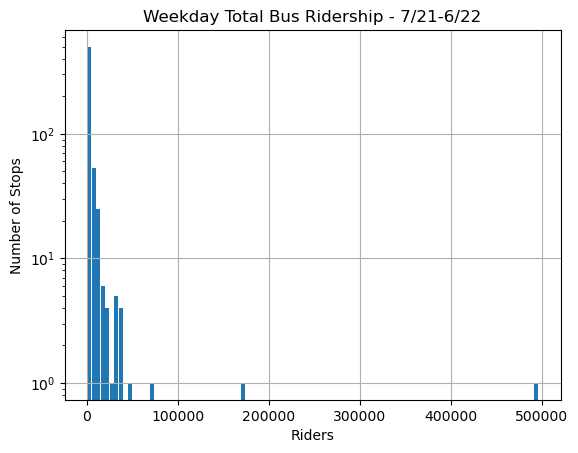

In [92]:
import matplotlib.pyplot as plt

yr_sbmtd_geo_all.weekday_ons.plot.hist(grid=True, bins=100, rwidth=0.9, log=True,
                                          title='Weekday Total Bus Ridership - 7/21-6/22')
plt.xlabel('Riders')
plt.ylabel('Number of Stops')

In [93]:
yr_sbmtd_geo_all >> filter(_.weekday_ons>50000)

,calitp_itp_id,stop_id,stop_code,stop_name,geometry,STOP_ID_clean,STOP_NAME_clean,sat_ons,sun_ons,weekday_ons
47,293,282,42,UCSB North Hall Outbound,POINT (-119.84789 34.41521),42,UCSB North Hall Outbound,11273.0,10988.0,173425.0
106,293,262,4,Transit Center,POINT (-119.70360 34.42095),4,Transit Center,65480.0,53731.0,496433.0
111,293,369,51,El Colegio & Camino Corto,POINT (-119.86597 34.41728),51,El Colegio/Camino Corto,7014.0,5460.0,70303.0
